<a href="https://colab.research.google.com/github/klopetx/PHM_python_lectures/blob/main/src/02_Feature_Extraction_II_time_frequency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

project_path = 'PHM_python_lectures'


if not os.path.isdir(project_path):

  from google.colab import userdata
  gitpass = userdata.get('gpass')
  mailpass = userdata.get('mailpass')
  mytoken = userdata.get('mytoken')


  !git config --global user.name "klopetx"
  !git config --global user.email "klopetx@gmail.com"
  !git config --global user.password gitpass


  token = mytoken
  username = 'klopetx'
  repo = 'PHM_python_lectures'


  !git clone https://{token}@github.com/{username}/{repo}

os.chdir(project_path)

!python src/00_Environment_Checks.py

FEMTO dataset is already downloaded.


# Feature extraction

We just so how ward it is to obtain meaningfull informaton from raw signals.
That is why we try to characterize them in indicators/features/kpis so that we can summarise the content of the signal into meaningful data that represent how the signals has behaved.

In addition, time domain features are sometimes not relevant enough to obtain meaningful information. In this notebook we will focus on the frequency domain.

## Frequency domain features

As we know, rotating machines tend to have a rotating part or parts which creates a reccurring oscillation. For that reason, using frequency domain features is of great interest, as they remove the noise and obtain the information related to specific rotating parts.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

target_file = 'data/10. FEMTO Bearing/Full_Test_Set/Bearing2_5/acc_00001.csv'

df = pd.read_csv(target_file, header=None)

signal_series = df.iloc[:, 4]
print(signal_series)

0       0.441
1       0.148
2      -0.042
3      -0.489
4      -0.385
        ...  
2555   -0.271
2556    0.032
2557   -0.441
2558   -0.275
2559   -0.231
Name: 4, Length: 2560, dtype: float64


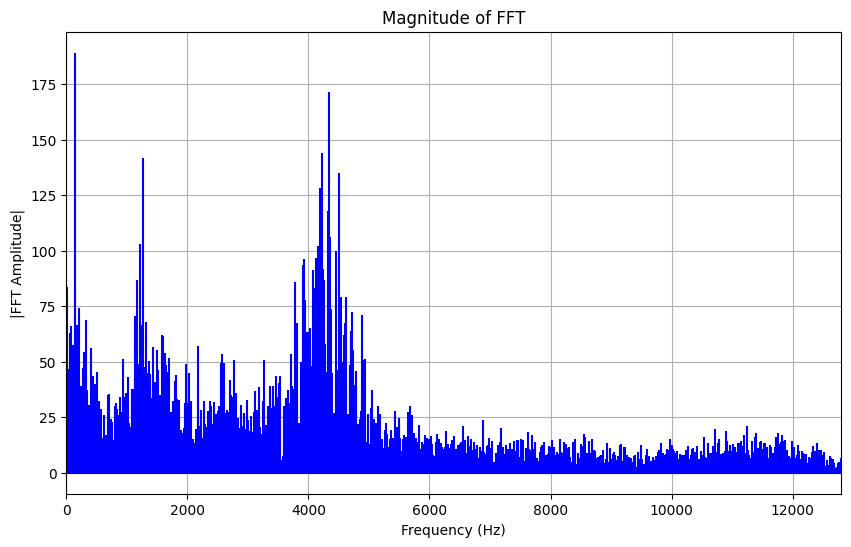

In [ ]:
fs = 25600

fft_result = np.fft.fft(signal_series)
fft_freq = np.fft.fftfreq(signal_series.size, d=1/fs)

# Plot FFT
plt.figure(figsize=(10, 6))
plt.stem(fft_freq, np.abs(fft_result), 'b', markerfmt=" ", basefmt="b")
plt.title('Magnitude of FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT Amplitude|')
plt.xlim(0, fs/2)  # Only plot positive frequencies
plt.grid()
plt.show()

In [ ]:
def concatenate_files(directory_path, file_prefix, one_in=1):
    """
    Concatenates files in the specified directory that start with the given prefix into a single DataFrame,
    selecting files according to the 'one_in' parameter. Logs the number of listed and read files.

    Parameters:
    - directory_path (str): The path to the directory containing the files.
    - file_prefix (str): The prefix of the files to be concatenated (e.g., 'acc_' or 'temp_').
    - one_in (int): Interval of files to be read. For example, one_in=2 reads every second file.

    Returns:
    - pd.DataFrame: A DataFrame containing the concatenated data from the selected files.
    """

    concatenated_df = pd.DataFrame()
    files_to_read = [filename for filename in os.listdir(directory_path) if filename.startswith(file_prefix)]
    files_to_read.sort()  # Ensure files are processed in order
    print(f"Total number of listed files with prefix '{file_prefix}': {len(files_to_read)}")

    files_read = 0  # Initialize counter for the number of files actually read
    for i, filename in enumerate(files_to_read):
        if i % one_in == 0:  # Process file based on one_in interval
            file_path = os.path.join(directory_path, filename)
            temp_df = pd.read_csv(file_path, header = None)
            temp_df['file_name'] = file_path
            concatenated_df = pd.concat([concatenated_df, temp_df], ignore_index=True)
            files_read += 1  # Increment the counter

    print(f"Number of files read (based on one_in={one_in}): {files_read}")

    return concatenated_df


In [ ]:
path = "/content/PHM_python_lectures/data/10. FEMTO Bearing/Learning_set/Bearing1_1"
file_prefix = 'acc_'
one_in = 500  # Change as needed to read every second, third, etc., file

df = concatenate_files(path, file_prefix, one_in)

Total number of listed files with prefix 'acc_': 2803
Number of files read (based on one_in=500): 6


In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_fft_series_interactive(all_data, file_names, column_index, fs):
    """
    Interactively plots FFT of values for the specified column in 'all_data', grouped by 'file_name',
    with '/content/PHM_python_lectures/data/10. FEMTO Bearing/Learning_set/' removed from the file names in the legend.

    Parameters:
    - all_data (pd.DataFrame): DataFrame containing the data.
    - file_names (list of str): List of file names to plot FFTs for.
    - column_index (int): Index of the column to plot FFT for.
    - fs (int): Sampling frequency of the signal.
    """
    fig = go.Figure()
    prefix_to_remove = "/content/PHM_python_lectures/data/10. FEMTO Bearing/"

    for file_name in file_names:
        cleaned_file_name = file_name.replace(prefix_to_remove, "")  # Remove the prefix
        signal = all_data[all_data['file_name'] == file_name].iloc[:, column_index].values
        fft_result = np.fft.fft(signal)
        fft_freq = np.fft.fftfreq(len(signal), d=1/fs)

        fig.add_trace(go.Scatter(x=fft_freq, y=np.abs(fft_result),
                                 mode='lines', name=cleaned_file_name))

    fig.update_layout(title='FFT Plot by File Name',
                      xaxis_title='Frequency (Hz)',
                      yaxis_title='Magnitude',
                      legend_title="File Names")
    fig.update_xaxes(range=[0, fs/2])  # Only plot positive frequencies
    fig.show()


def plot_fft_series(all_data, file_names, column_index, fs):
    """
    Plots FFT of values for the specified column in 'all_data', grouped by 'file_name'.

    Parameters:
    - all_data (pd.DataFrame): DataFrame containing the data.
    - file_names (list of str): List of file names to plot FFTs for.
    - column_index (int): Index of the column to plot FFT for.
    - fs (int): Sampling frequency of the signal.
    """

    plt.figure(figsize=(10, 5))
    colors = plt.cm.jet(np.linspace(0, 1, len(file_names)))

    for file_name, color in zip(file_names, colors):
        # Filter data for the current file name and extract the specified column
        signal = all_data[all_data['file_name'] == file_name].iloc[:, column_index].values

        # Compute FFT
        fft_result = np.fft.fft(signal)
        fft_freq = np.fft.fftfreq(len(signal), d=1/fs)

        # Plot FFT
        plt.plot(fft_freq, np.abs(fft_result), label=file_name, color=color)

    plt.title('FFT Plot by File Name')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.xlim(0, fs/2)  # Only plot positive frequencies
    plt.grid()
    plt.show()

In [ ]:
target_files = df.file_name.value_counts().index.to_list()


In [ ]:
column_index = 4
fs = 25600
plot_fft_series_interactive(df, target_files, column_index, fs)

In [ ]:
column_index = 4
fs = 25600
plot_fft_series_interactive(df, target_files, column_index, fs)

In [ ]:
different_oc_files = ["/content/PHM_python_lectures/data/10. FEMTO Bearing/Full_Test_Set/Bearing3_3/acc_00001.csv","/content/PHM_python_lectures/data/10. FEMTO Bearing/Learning_set/Bearing1_1/acc_00001.csv"]




In [ ]:
path = "/content/PHM_python_lectures/data/10. FEMTO Bearing/Full_Test_Set/Bearing3_3"
file_prefix = 'acc_'
one_in = 100  # Change as needed to read every second, third, etc., file

new_bearing = concatenate_files(path, file_prefix, one_in)

Total number of listed files with prefix 'acc_': 434
Number of files read (based on one_in=100): 5


In [ ]:
new_dataset = pd.concat([df, new_bearing], ignore_index=True)

print(new_dataset.file_name.value_counts().index)

print(different_oc_files)

Index(['/content/PHM_python_lectures/data/10. FEMTO Bearing/Learning_set/Bearing1_1/acc_00001.csv',
       '/content/PHM_python_lectures/data/10. FEMTO Bearing/Learning_set/Bearing1_1/acc_00501.csv',
       '/content/PHM_python_lectures/data/10. FEMTO Bearing/Learning_set/Bearing1_1/acc_01001.csv',
       '/content/PHM_python_lectures/data/10. FEMTO Bearing/Learning_set/Bearing1_1/acc_01501.csv',
       '/content/PHM_python_lectures/data/10. FEMTO Bearing/Learning_set/Bearing1_1/acc_02001.csv',
       '/content/PHM_python_lectures/data/10. FEMTO Bearing/Learning_set/Bearing1_1/acc_02501.csv',
       '/content/PHM_python_lectures/data/10. FEMTO Bearing/Full_Test_Set/Bearing3_3/acc_00001.csv',
       '/content/PHM_python_lectures/data/10. FEMTO Bearing/Full_Test_Set/Bearing3_3/acc_00101.csv',
       '/content/PHM_python_lectures/data/10. FEMTO Bearing/Full_Test_Set/Bearing3_3/acc_00201.csv',
       '/content/PHM_python_lectures/data/10. FEMTO Bearing/Full_Test_Set/Bearing3_3/acc_00301.cs

In [ ]:
plot_fft_series_interactive(new_dataset, different_oc_files, column_index, fs)

## Filtering the signal

As we can see, there is some noise in the signal, there are different ways of removing such noise.




In [ ]:
import plotly.graph_objects as go
from scipy.signal import butter, lfilter
from scipy.fft import fft, fftfreq
import numpy as np

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data)
    return filtered_data

# Function to compute FFT
def compute_fft(signal, fs):
    N = len(signal)
    fft_result = fft(signal)
    fft_freq = fftfreq(N, 1/fs)
    return fft_freq, np.abs(fft_result)


signal = signal_series.index.values
# Apply the low-pass filter
cutoff_frequency = 10000  # Hz
sampling_frequency = 25600  # Hz
order = 6
# Assuming 'signal' is your accelerometer signal from the FEMTO Bearing Dataset
filtered_signal = butter_lowpass_filter(signal, cutoff_frequency, sampling_frequency, order)

# Compute FFT for both original and filtered signals
fft_freq, original_fft = compute_fft(signal, sampling_frequency)
_, filtered_fft = compute_fft(filtered_signal, sampling_frequency)

# Plot the results side by side using Plotly
fig = go.Figure()

# Original Signal FFT
fig.add_trace(go.Scatter(x=fft_freq, y=original_fft,
                         mode='lines', name='Original Signal FFT'))

# Filtered Signal FFT
fig.add_trace(go.Scatter(x=fft_freq, y=filtered_fft,
                         mode='lines', name='Filtered Signal FFT'))

fig.update_layout(title_text='FFT Comparison: Original vs. Filtered Signal',
                  xaxis_title='Frequency (Hz)',
                  yaxis_title='Magnitude',
                  xaxis_rangeslider_visible=True)
fig.update_xaxes(range=[0, sampling_frequency/2])  # Only plot positive frequencies
fig.show()